# Preliminary Work

In [ ]:
%run Template.ipynb

In [16]:
def load_audio(audio_path):
    return librosa.load(audio_path, sr=None)

def logMelSpectrogram(audio, fe, dt):
    # Spectrogram
    stfts = np.abs(librosa.stft(audio,
                        n_fft = int(dt*fe),
                        hop_length = int(dt*fe),
                        center = True
                        )).T
    num_spectrogram_bins = stfts.shape[-1]
    # MEL filter
    linear_to_mel_weight_matrix = librosa.filters.mel(
                                sr=fe,
                                n_fft=int(dt*fe) + 1,
                                n_mels=num_spectrogram_bins,
                    ).T

    # Apply the filter to the spectrogram
    mel_spectrograms = np.tensordot(
                stfts,
                linear_to_mel_weight_matrix,
                1
            )
    return np.log(mel_spectrograms + 1e-6)

def load_data(audio_path, dt=0.02, T_max=10):
    X_audio=[]
    for i, a_path in enumerate(audio_path) :
        # Load the audio file
        data, fe = load_audio(a_path)
            
        # For the audio > T_max : Use just the fist T_max seconde, to have the right shape. 
        if len(data)>= T_max*fe:
            data = data[:int(T_max*fe)]
        
        # For the audio < T_max : Add in the signal a zeros vector, to have the right shape.
        else :
            data = np.concatenate([data, np.zeros(int(T_max*fe - len(data)))])
            
        # Apply the logMelSpectrogram function.    
        spectre_audio = logMelSpectrogram(data, fe, dt)
        X_audio.append(spectre_audio)
    return np.array(X_audio)

In [3]:
df = pd.read_csv('Fichiers_output_Projet/fichiers_son.csv')
df.head()

df_fan = df[ df['Machine']== 'fan' ] # sélection de la machine fan
df_fan_test = df_fan[df['train_test'] == 'train'] # sélection du dataset train
df_fan_test['Machine_ID'] = df_fan_test['Machine_ID'].replace(to_replace = [0, 2, 4, 6], value = [0,1,2,3])


X = df_fan_test['URL']
y = df_fan_test['Machine_ID']


X_train_path, X_test_path, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)
Y_train = Y_train.values
Y_test = Y_test.values

<ipython-input-3-69a16a076d51>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fan_test = df_fan[df['train_test'] == 'train'] # sélection du dataset train
<ipython-input-3-69a16a076d51>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fan_test['Machine_ID'] = df_fan_test['Machine_ID'].replace(to_replace = [0, 2, 4, 6], value = [0,1,2,3])


In [4]:
X_train = load_data(X_train_path)
X_test = load_data(X_test_path)

/opt/anaconda3/envs/soundAnomaly/lib/python3.8/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


In [5]:
X_train.shape[1:]

(501, 161)

In [6]:
X_train.shape

(2940, 501, 161)

In [7]:
X_test.shape

(735, 501, 161)

In [8]:
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
print(X_train.shape)
print(X_test.shape)

(2940, 80661)
(735, 80661)


In [9]:
input_img = keras.Input(shape=(80661,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(80661)(decoded)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))


Epoch 1/10
12/12 [==============================] - 11s 909ms/step - loss: 24.8762 - val_loss: 2.9769
Epoch 2/10
12/12 [==============================] - 9s 741ms/step - loss: 1.7330 - val_loss: 0.9179
Epoch 3/10
12/12 [==============================] - 8s 649ms/step - loss: 0.6392 - val_loss: 0.4986
Epoch 4/10
12/12 [==============================] - 8s 655ms/step - loss: 0.4633 - val_loss: 0.4261
Epoch 5/10
12/12 [==============================] - 9s 716ms/step - loss: 0.4165 - val_loss: 0.3994
Epoch 6/10
12/12 [==============================] - 8s 673ms/step - loss: 0.4026 - val_loss: 0.3926
Epoch 7/10
12/12 [==============================] - 9s 712ms/step - loss: 0.3987 - val_loss: 0.3911
Epoch 8/10
12/12 [==============================] - 8s 678ms/step - loss: 0.3974 - val_loss: 0.3906
Epoch 9/10
12/12 [==============================] - 9s 730ms/step - loss: 0.3971 - val_loss: 0.3907
Epoch 10/10
12/12 [==============================] - 8s 691ms/step - loss: 0.3970 - val_loss: 0.39

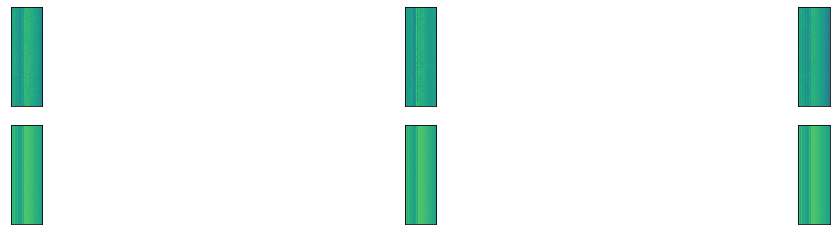

In [10]:
decoded_imgs = autoencoder.predict(X_test)

n = 3
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(501, 161))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(501, 161))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


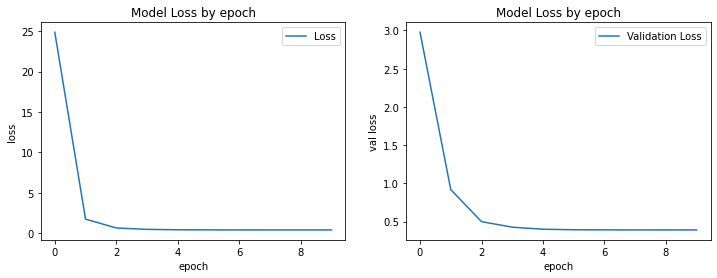

In [11]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'], 
         label = 'Loss')
plt.title('Model Loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(122)
plt.plot(history.history['val_loss'], 
         label = 'Validation Loss')
plt.title('Model Loss by epoch')
plt.ylabel('val loss')
plt.xlabel('epoch')
plt.legend()

# Affichage de la figure
plt.show()

In [17]:
def load_data(audio_path, dt=0.5, T_max=10):
    X_audio=[]
    for i, a_path in enumerate(audio_path) :
        # Load the audio file
        data, fe = load_audio(a_path)
            
        # For the audio > T_max : Use just the fist T_max seconde, to have the right shape. 
        if len(data)>= T_max*fe:
            data = data[:int(T_max*fe)]
        
        # For the audio < T_max : Add in the signal a zeros vector, to have the right shape.
        else :
            data = np.concatenate([data, np.zeros(int(T_max*fe - len(data)))])
            
        # Apply the logMelSpectrogram function.    
        spectre_audio = logMelSpectrogram(data, fe, dt)
        X_audio.append(spectre_audio)
    return np.array(X_audio)

In [13]:
X_train = load_data(X_train_path)
X_test = load_data(X_test_path)

In [14]:
X_train.shape

(2940, 21, 4001)

In [15]:
X_train = X_train[:, :16, :4000]
X_train.shape

(2940, 16, 4000)

In [17]:
X_test = X_test[:, :16, :4000]
X_test.shape

(735, 16, 4000)

In [18]:
import keras
from keras import layers

X_train = X_train.reshape((-1, 16, 4000, 1))
X_test = X_test.reshape((-1, 16, 4000, 1))

input_img = keras.Input(shape=(16, 4000, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), padding='same')(x)


autoencoder3D = keras.Model(input_img, decoded)
autoencoder3D.compile(optimizer='adam', loss='mse')

autoencoder3D.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16, 4000, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 4000, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 2000, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 2000, 8)        1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 1000, 8)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 1000, 8)        584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 500, 8)        

In [19]:
history3D = autoencoder3D.fit(X_train, X_train,
                              epochs=10,
                              batch_size=126,
                              shuffle=True,
                              validation_data=(X_test, X_test))

Epoch 1/10
24/24 [==============================] - 304s 13s/step - loss: 17.5258 - val_loss: 13.3709
Epoch 2/10
24/24 [==============================] - 299s 12s/step - loss: 12.4786 - val_loss: 12.0594
Epoch 3/10
24/24 [==============================] - 292s 12s/step - loss: 12.0009 - val_loss: 11.9752
Epoch 4/10
24/24 [==============================] - 291s 12s/step - loss: 11.9511 - val_loss: 11.9412
Epoch 5/10
24/24 [==============================] - 283s 12s/step - loss: 11.9229 - val_loss: 11.9197
Epoch 6/10
24/24 [==============================] - 350s 15s/step - loss: 11.9040 - val_loss: 11.9029
Epoch 7/10
24/24 [==============================] - 370s 15s/step - loss: 11.8872 - val_loss: 11.8862
Epoch 8/10
24/24 [==============================] - 290s 12s/step - loss: 11.8707 - val_loss: 11.8697
Epoch 9/10
24/24 [==============================] - 232s 10s/step - loss: 11.8536 - val_loss: 11.8522
Epoch 10/10
24/24 [==============================] - 222s 9s/step - loss: 11.8363 

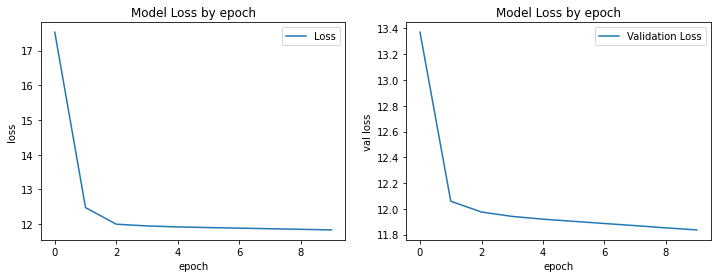

In [20]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history3D.history['loss'], 
         label = 'Loss')
plt.title('Model Loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(122)
plt.plot(history3D.history['val_loss'], 
         label = 'Validation Loss')
plt.title('Model Loss by epoch')
plt.ylabel('val loss')
plt.xlabel('epoch')
plt.legend()

# Affichage de la figure
plt.show()

# ENTRAINEMENT SUR LE TEST ET DETECTION ANOMALY

In [8]:
autoencoder3D = keras.models.load_model("AE_3D.joblib")

In [25]:
df.head()

,Unnamed: 0,URL,fichier,train_test,Machine,Machine_ID,son_type,duree_son
0,3,archive/ToyCar/test/normal_id_02_00000055.wav,normal_id_02_00000055.wav,test,ToyCar,2,normal,11.0
1,4,archive/ToyCar/test/normal_id_02_00000064.wav,normal_id_02_00000064.wav,test,ToyCar,2,normal,11.0
2,5,archive/ToyCar/test/normal_id_02_00000031.wav,normal_id_02_00000031.wav,test,ToyCar,2,normal,11.0
3,6,archive/ToyCar/test/normal_id_02_00000027.wav,normal_id_02_00000027.wav,test,ToyCar,2,normal,11.0
4,7,archive/ToyCar/test/normal_id_02_00000024.wav,normal_id_02_00000024.wav,test,ToyCar,2,normal,11.0


In [18]:
df_fan_test = df_fan[df['train_test'] == 'test'] # sélection du dataset train
df_fan_test['son_type'] = df_fan_test['son_type'].replace(to_replace = ["normal", "anomaly"], value = [-1,1])


X = df_fan_test['URL']
y = df_fan_test['son_type']


X_train_path, X_test_path, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)
Y_train = Y_train.values
Y_test = Y_test.values

<ipython-input-18-f742df6221bd>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fan_test = df_fan[df['train_test'] == 'test'] # sélection du dataset train
<ipython-input-18-f742df6221bd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fan_test['son_type'] = df_fan_test['son_type'].replace(to_replace = ["normal", "anomaly"], value = [-1,1])


In [19]:
X_train = load_data(X_train_path)
X_test = load_data(X_test_path)

/opt/anaconda3/envs/soundAnomaly/lib/python3.8/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


In [20]:
X_train = X_train[:, :16, :4000]
X_train.shape

(1500, 16, 4000)

In [21]:
X_test = X_test[:, :16, :4000]
X_test.shape

(375, 16, 4000)

In [15]:
X_train = X_train.reshape((-1, 16, 4000, 1))
X_test = X_test.reshape((-1, 16, 4000, 1))

history3D_test = autoencoder3D.fit(X_train, X_train,
                                   epochs=100,
                                   batch_size=126,
                                   shuffle=True,
                                   validation_data=(X_test, X_test))

ValueError: cannot reshape array of size 3864000 into shape (16,4000,1)

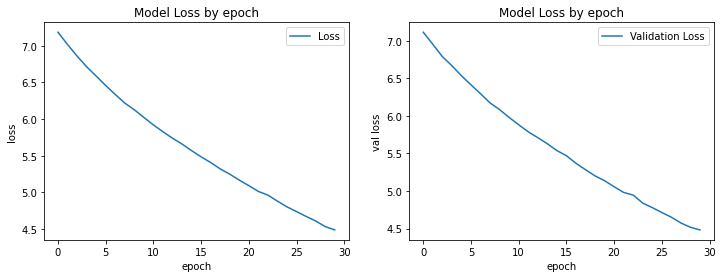

In [91]:
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history3D_test.history['loss'], 
         label = 'Loss')
plt.title('Model Loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(122)
plt.plot(history3D_test.history['val_loss'], 
         label = 'Validation Loss')
plt.title('Model Loss by epoch')
plt.ylabel('val loss')
plt.xlabel('epoch')
plt.legend()

# Affichage de la figure
plt.show()

In [92]:
X_test.shape

(375, 16, 4000, 1)

In [93]:
Y_pred_test = autoencoder3D.predict(X_test)
Y_pred_test.shape

(375, 16, 4000, 1)

In [94]:
X_test = X_test.reshape((-1, 16*4000))
X_test.shape

(375, 64000)

In [95]:
Y_pred_test = Y_pred_test.reshape((-1, 16*4000))
Y_pred_test.shape

(375, 64000)

In [96]:
mse_files = []
for i in range(len(X_test)):
    diff = np.mean(X_test[i,:] - Y_pred_test[i,:]) # pour le fichier i la moyenne des différences de valeur de pixel pour chaque indice
    mse_files.append(diff**2)
# sinon pour diff on aurait surement pu X_test - Y_pred_test avec axis = pour préciser la dimension : ici 2 
#mse_files

In [102]:
mse_files = []
for i in range(len(X_test)):
    diff_carres = np.mean(X_test[i,:]**2 - Y_pred_test[i,:]**2) # pour le fichier i la moyenne des différences de valeur de pixel pour chaque indice
    mse_files.append(diff_carres)

In [109]:
mse_files = []
for i in range(len(X_test)):
    diff_carres = mean_absolute_error(X_test[i,:],Y_pred_test[i,:])
    mse_files.append(diff_carres)

In [107]:
from sklearn.metrics import mean_absolute_error
score = mean_absolute_error(X_test,Y_pred_test)

In [108]:
score

1.2644994

In [97]:
len(mse_files)

375

Comparer la mse des fichiers normaux et anormaux:

In [98]:
len(Y_test)
#Y_test

375

In [110]:
anomalies = []
for i in range(len(mse_files)):
    if Y_test[i] == -1:
        anomalies.append(mse_files[i])

anomalies_arr = np.array(anomalies)
anomalies_arr
np.mean(anomalies_arr)

1.2654178

In [111]:
normaux = []
for i in range(len(mse_files)):
    if Y_test[i] == 1:
        normaux.append(mse_files[i])

normaux_arr = np.array(normaux)
normaux_arr
np.mean(normaux_arr)

1.2642502

In [112]:
autoencoder3D.save('AE_3D.joblib')

INFO:tensorflow:Assets written to: AE_3D.joblib/assets
